

Lists of:
- First name
- Middle name
- Last name

- City and State
def # dfd
- Dates of birth (generated)

Analyze the similarity of  di



# Library

In [46]:
import math
import random
import string

import pandas as pd

import tokenizer

LETTERS = string.ascii_lowercase


def one_letter_edits(s):
    return random.sample(
        random.sample(sum([[s[:i] + c + s[i:] for c in LETTERS] for i in range(len(s) + 1)], []), 10) +
        [s[:i] + s[i + 1:] for i in range(len(s))] +
        random.sample(sum([[s[:i] + c + s[i + 1:] for c in LETTERS if c != s[i]] for i in range(len(s))], []), 10)
    , 10)


def two_letter_edits(s):
    return random.sample(set([e2 for e1 in one_letter_edits(s) for e2 in one_letter_edits(e1)]) - {s}, 10)


# Parameters

EPS = 3
L = 1000
KN = int(L/math.log(L))


# Single field tokenizer


In [56]:
first_names = [
    tokenizer.normalize_name(name)
    for name in open("data/first-names.txt").read().splitlines()
]

rows = []

print("Adding pairs of names with no edits")
for name in first_names:
    rows.append([
            name,
            name,
            tokenizer.tokenize_name(L, KN, EPS, name, prefix=""),
            tokenizer.tokenize_name(L, KN, EPS, name, prefix=""),
            "Same",
            True
        ])

print("Adding pairs of names with one letter edit")
for name in first_names:
    for edited in one_letter_edits(name):
        rows.append([
                name,
                edited,
                tokenizer.tokenize_name(L, KN, EPS, name, prefix=""),
                tokenizer.tokenize_name(L, KN, EPS, edited, prefix=""),
                "One letter edit",
                True
            ])
        
print("Adding pairs of names with two letter edits")
for name in first_names:
    for edited in two_letter_edits(name):
        rows.append([
            name,
            edited,
            tokenizer.tokenize_name(L, KN, EPS, name, prefix=""),
            tokenizer.tokenize_name(L, KN, EPS, edited, prefix=""),
            "Two letter edits",
            True
        ])

print("Adding pairs of different names")
for name in first_names:
    for other in random.sample(first_names, 2):
        if name != other:
            rows.append([
                name,
                other,
                tokenizer.tokenize_name(L, KN, EPS, name, prefix=""),
                tokenizer.tokenize_name(L, KN, EPS, other, prefix=""),
                "Other name",
                False
            ])

df = pd.DataFrame(rows, columns=["name1", "name2", "token1", "token2", "type", "same"])


Adding pairs of names with no edits
Adding pairs of names with one letter edit
Adding pairs of names with two letter edits


/tmp/ipykernel_3092034/1060681128.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(set([e2 for e1 in one_letter_edits(s) for e2 in one_letter_edits(e1)]) - {s}, 10)


Adding pairs of different names


In [48]:
def similarity(a, b) -> float:
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

df["similarity"] = df.apply(lambda row: similarity(row.token1, row.token2), axis=1)
df["dice"] = df.apply(lambda row: tokenizer.dice(row.token1, row.token2), axis=1)

In [55]:
from IPython.display import display
import numpy as np
from sklearn.metrics import precision_score, recall_score


for THRESHOLD in [THRESHOLD_MATCH, THRESHOLD_LIKELY, THRESHOLD_MAYBE]:
    records = []
    different_truth = [False] * len(df[df.same == False])
    different_similarity = df[df.same == False].similarity.values

    for group_name in ["Same", "One letter edit", "Two letter edits"]:
        group = df[df.type == group_name]
        y_true = list(group.same) + different_truth
        similarities = list(group.similarity.values) +list(different_similarity)
        y_pred = [x > THRESHOLD for x in similarities]
        records.append({
            "Threshold": THRESHOLD,
            "Name": group_name,
            "Precision": precision_score(y_true, y_pred).round(2),
            "Recall": recall_score(y_true, y_pred).round(2),
            "Epsilon": EPS,
        })

    display(pd.DataFrame.from_records(records, index="Threshold".split()))


,Name,Precision,Recall,Epsilon
Threshold,,,,
0.832,Same,1.0,1.00,3
0.832,One letter edit,1.0,0.69,3
0.832,Two letter edits,1.0,0.24,3


,Name,Precision,Recall,Epsilon
Threshold,,,,
0.758,Same,0.91,1.00,3
0.758,One letter edit,0.99,0.99,3
0.758,Two letter edits,0.99,0.89,3


,Name,Precision,Recall,Epsilon
Threshold,,,,
0.708,Same,0.39,1.00,3
0.708,One letter edit,0.86,1.00,3
0.708,Two letter edits,0.86,0.99,3


# Precision recall curves for each group

Match threshold set: t=0.832, precision=0.9990243902439024, recall=1.0
Likely threshold set: t=0.758, precision=0.9896743641068203, recall=0.9898193359375
Maybe threshold set: t=0.708, precision=0.8587871208427835, recall=0.9891357421875


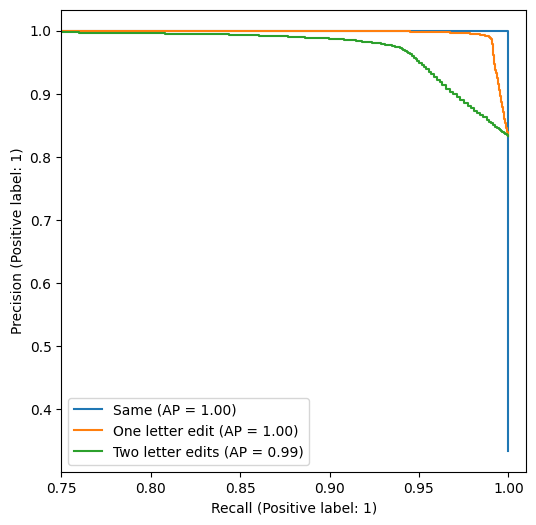

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay


_, ax = plt.subplots(figsize=(6, 6))

THRESHOLD_MATCH = -1
THRESHOLD_LIKELY = -1
THRESHOLD_MAYBE = -1

for group_name in ["Same", "One letter edit", "Two letter edits"]:
    group = df[df.type == group_name]
    y_true = list(group.same) + different_truth
    similarities = list(group.similarity.values) +list(different_similarity)
    precision, recall, thresholds = precision_recall_curve(y_true, similarities)

    if group_name == "Same":
        for p, r, t in zip(precision, recall, thresholds):
            if p > 0.999:
                THRESHOLD_MATCH = t
                print(f"Match threshold set: t={t}, precision={p}, recall={r}")
                break
    if group_name == "One letter edit":
        for p, r, t in zip(precision, recall, thresholds):
            if r < 0.99:
                THRESHOLD_LIKELY = t
                print(f"Likely threshold set: t={t}, precision={p}, recall={r}")
                break
    if group_name == "Two letter edits":
        for p, r, t in zip(precision, recall, thresholds):
            if r < 0.99:
                THRESHOLD_MAYBE = t
                print(f"Maybe threshold set: t={t}, precision={p}, recall={r}")
                break

    PrecisionRecallDisplay.from_predictions(y_true, similarities, ax=ax, name=group_name)

ax.set_xlim(0.75, 1.01)
pass

# Comparison of Dice coefficient and similarity


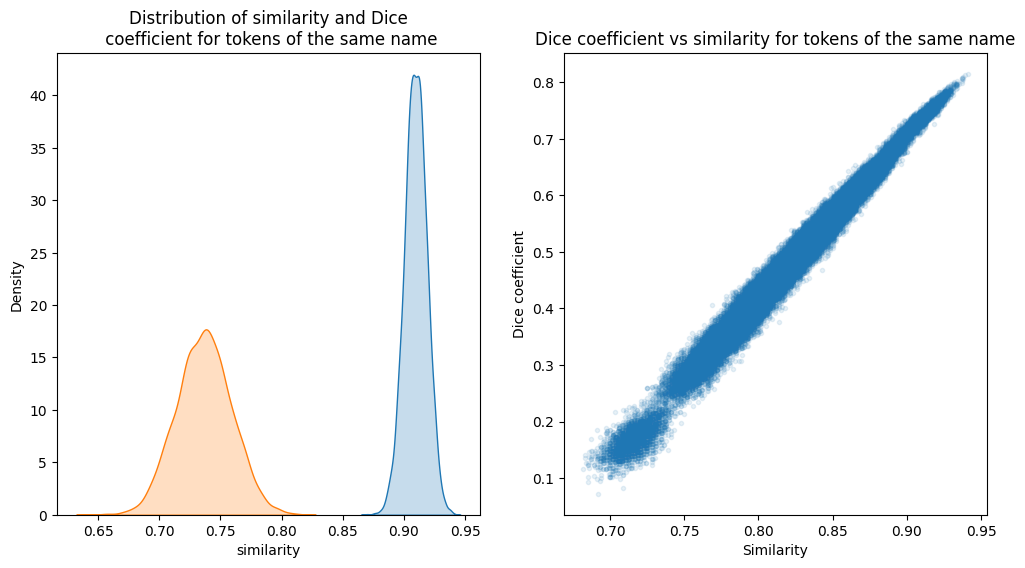

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(df.similarity[df.type == "Same"], fill=True, ax=axs[0])
sns.kdeplot(df.dice[df.type == "Same"], fill=True, ax=axs[0])
axs[0].set_title("Distribution of similarity and Dice\n coefficient for tokens of the same name")

axs[1].plot(df[df.same == True].similarity, df[df.same == True].dice, '.', alpha=0.1)
axs[1].set_xlabel("Similarity")
axs[1].set_ylabel("Dice coefficient")
axs[1].set_title("Dice coefficient vs similarity for tokens of the same name")

# TODO: plot for different epsilons

pass
    

# Get most and least similar names for each group

In [52]:
for group in ["Same", "One letter edit", "Two letter edits", "Other name"]:
    print("Checking values with highest and lowest similarity in group:" + group)
    display(df[df.type == group].sort_values("similarity", ascending=False).head(10))
    display(df[df.type == group].sort_values("similarity", ascending=True).head(10))
    print(10*(150*"-" + "\n"))


Checking values with highest and lowest similarity in group:Same


,name1,name2,token1,token2,type,same,similarity,dice
2164,ladie,ladie,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Same,True,0.941,0.815047
3763,teegan,teegan,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",Same,True,0.939,0.813456
3588,sloan,sloan,"[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",Same,True,0.938,0.805031
2127,krag,krag,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...",Same,True,0.938,0.808642
344,azalea,azalea,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Same,True,0.937,0.807339
173,amma,amma,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",Same,True,0.937,0.806154
2051,kennedy,kennedy,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",Same,True,0.937,0.807339
761,clotilde,clotilde,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Same,True,0.937,0.798722
2341,lorraine,lorraine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...",Same,True,0.937,0.802508
3538,shilpa,shilpa,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Same,True,0.935,0.796238


,name1,name2,token1,token2,type,same,similarity,dice
991,dierkes,dierkes,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",Same,True,0.870,0.644809
721,christinne,christinne,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Same,True,0.875,0.671916
620,carrie,carrie,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Same,True,0.877,0.664850
1927,juli,juli,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Same,True,0.877,0.659280
1372,gemma,gemma,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Same,True,0.880,0.655172
947,demetri,demetri,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",Same,True,0.880,0.685864
1755,janika,janika,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...",Same,True,0.881,0.659026
140,aluaro,aluaro,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Same,True,0.881,0.655072
1074,edwin,edwin,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",Same,True,0.882,0.681081
763,clément,clément,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",Same,True,0.882,0.670391


------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------

,name1,name2,token1,token2,type,same,similarity,dice
38542,schwemmer,chwemmer,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",One letter edit,True,0.919,0.746082
7820,bbmartinezgmailcom,bbmartinezgmailcomv,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",One letter edit,True,0.917,0.768802
23767,kalpakoglou,kalpakogloup,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",One letter edit,True,0.916,0.742331
17880,genevieve,jgenevieve,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",One letter edit,True,0.912,0.734940
11677,clemente,jclemente,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.912,0.738095
28105,macarena,macarenaw,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.912,0.723270
19223,hamburgesas,hamburgesask,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.912,0.739645
39359,sheridan,sheridaz,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",One letter edit,True,0.911,0.717460
37052,romualdo,romualdoc,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",One letter edit,True,0.911,0.715655
18447,giuseppe,igiuseppe,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.910,0.730539


,name1,name2,token1,token2,type,same,similarity,dice
24792,key,kjy,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...",One letter edit,True,0.683,0.136240
11883,con,cn,"[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.683,0.140921
40888,sun,sn,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",One letter edit,True,0.685,0.122563
40065,soe,swe,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",One letter edit,True,0.691,0.134454
21861,jay,joy,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",One letter edit,True,0.693,0.120344
42236,tip,tep,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",One letter edit,True,0.693,0.125356
43575,vip,vfp,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, ...",One letter edit,True,0.693,0.172507
37409,roy,rwy,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",One letter edit,True,0.695,0.135977
36731,rob,rpb,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.695,0.131054
30360,me,ma,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",One letter edit,True,0.696,0.160221


------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------

,name1,name2,token1,token2,type,same,similarity,dice
61701,iromi,mirom,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.922,0.774566
66560,krysten,kryste,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.921,0.742671
83572,treweek,treewek,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.917,0.750751
75272,patricia,paatricia,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.908,0.724551
45660,alaeddin,alaeddinz,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Two letter edits,True,0.905,0.721408
80378,shewatsehai,shewatsehao,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.904,0.715976
72631,morice,morices,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.904,0.696203
50458,brookelyn,rookelyn,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.903,0.699690
79503,schwemmer,sschwemmer,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...",Two letter edits,True,0.902,0.715116
74237,novian,novians,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...",Two letter edits,True,0.902,0.703030


,name1,name2,token1,token2,type,same,similarity,dice
49646,block,bmolk,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Two letter edits,True,0.682,0.116667
67559,lever,lvhr,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.684,0.127072
56219,els,aes,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",Two letter edits,True,0.685,0.102564
75022,pam,psai,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.685,0.127424
54512,dema,pea,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",Two letter edits,True,0.685,0.122563
63577,joan,yohn,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.685,0.092219
56088,eliza,egina,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",Two letter edits,True,0.686,0.117978
67803,lili,lvidi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Two letter edits,True,0.686,0.137363
66787,lang,daag,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, ...",Two letter edits,True,0.686,0.146739
62393,james,jmis,"[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...",Two letter edits,True,0.687,0.137741


------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------

,name1,name2,token1,token2,type,same,similarity,dice
86683,avila,villa,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Other name,False,0.872,0.630058
87801,daria,darius,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other name,False,0.835,0.532578
91065,marith,marian,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other name,False,0.834,0.508876
91746,nidia,donia,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Other name,False,0.832,0.490909
87800,daria,adria,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Other name,False,0.827,0.480480
92275,rachael,michael,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Other name,False,0.826,0.524590
90872,maika,laima,"[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Other name,False,0.818,0.448485
88661,fransisco,fransua,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",Other name,False,0.816,0.477273
88403,estss,jesse,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",Other name,False,0.814,0.456140
92967,shadi,nesha,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other name,False,0.814,0.443114


,name1,name2,token1,token2,type,same,similarity,dice
93616,thue,salazar,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",Other name,False,0.671,0.122667
87962,dhana,rogerio,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, ...",Other name,False,0.674,0.114130
91781,ninua,jacquie,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",Other name,False,0.679,0.110803
86790,belgica,shannon,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...",Other name,False,0.680,0.175258
86804,benay,diego,"[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Other name,False,0.680,0.106145
91018,mariano,schubert,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other name,False,0.680,0.135135
88765,genaro,stepahanie,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Other name,False,0.680,0.120879
90722,luc,tao,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",Other name,False,0.681,0.121212
86423,anduena,espie,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",Other name,False,0.682,0.106742
92792,sami,catherine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",Other name,False,0.682,0.131148


------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------